## Load Packages/Import Data

In [65]:
#load packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import date, timedelta
from statsmodels.tsa.stattools import adfuller

In [66]:
#import data
natural_gas = pd.read_csv("natural_gas.csv",parse_dates=['Dates'],index_col=['Dates'])
natural_gas.tail()

/var/folders/z_/9h44s4jd1_v60ytmp987cz8m0000gn/T/ipykernel_18542/2608116627.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  natural_gas = pd.read_csv("natural_gas.csv",parse_dates=['Dates'],index_col=['Dates'])


,Prices
Dates,
2024-05-31,11.4
2024-06-30,11.5
2024-07-31,11.6
2024-08-31,11.5
2024-09-30,11.8


In [67]:
len(natural_gas)

48

In [68]:
natural_gas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2020-10-31 to 2024-09-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Prices  48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


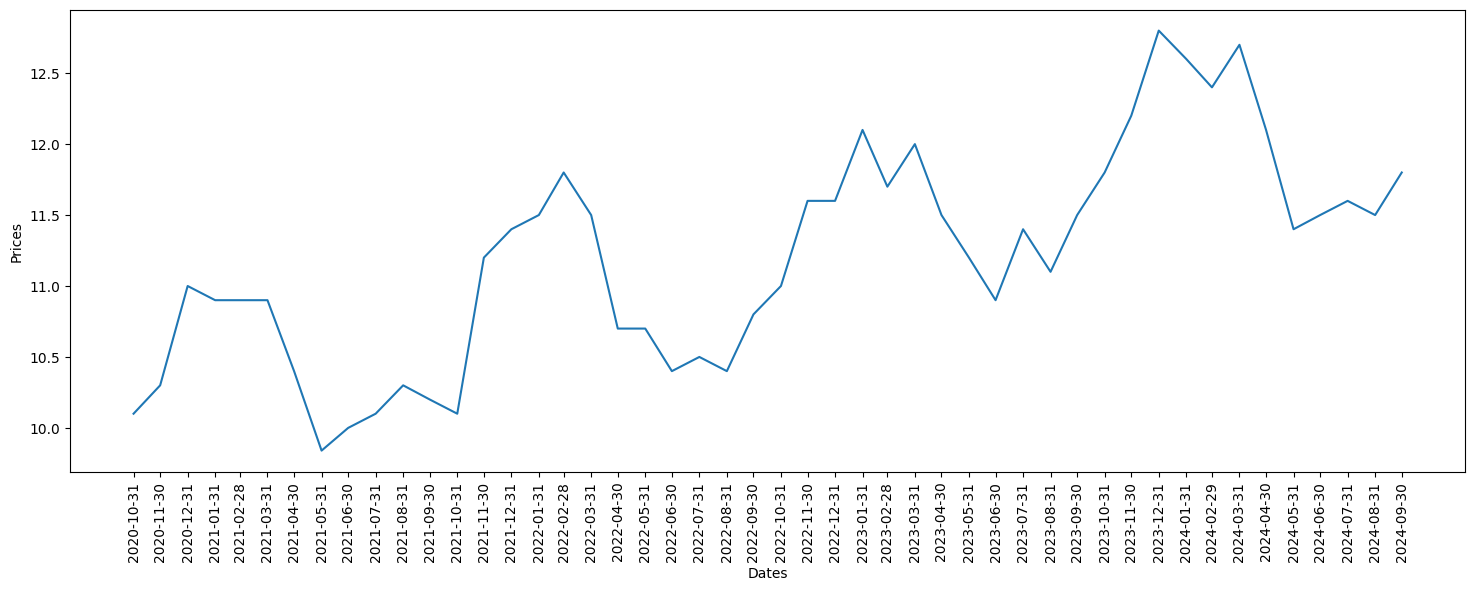

In [69]:
#plot the time series
plt.figure(figsize=(18,6))
plt.plot(natural_gas['Prices'])
plt.xticks(natural_gas.index,rotation=90)
plt.xlabel("Dates")
plt.ylabel("Prices")
plt.show()

Notes:
- seems like there is a seasonal trend, with prices being higher in the later months of the year to early of the next year, around october to april
- downward trend in the months may to october
- overall upward trend with prices getting more expensive every year
- linear upward trend

## Analyze Seasonality and Trend

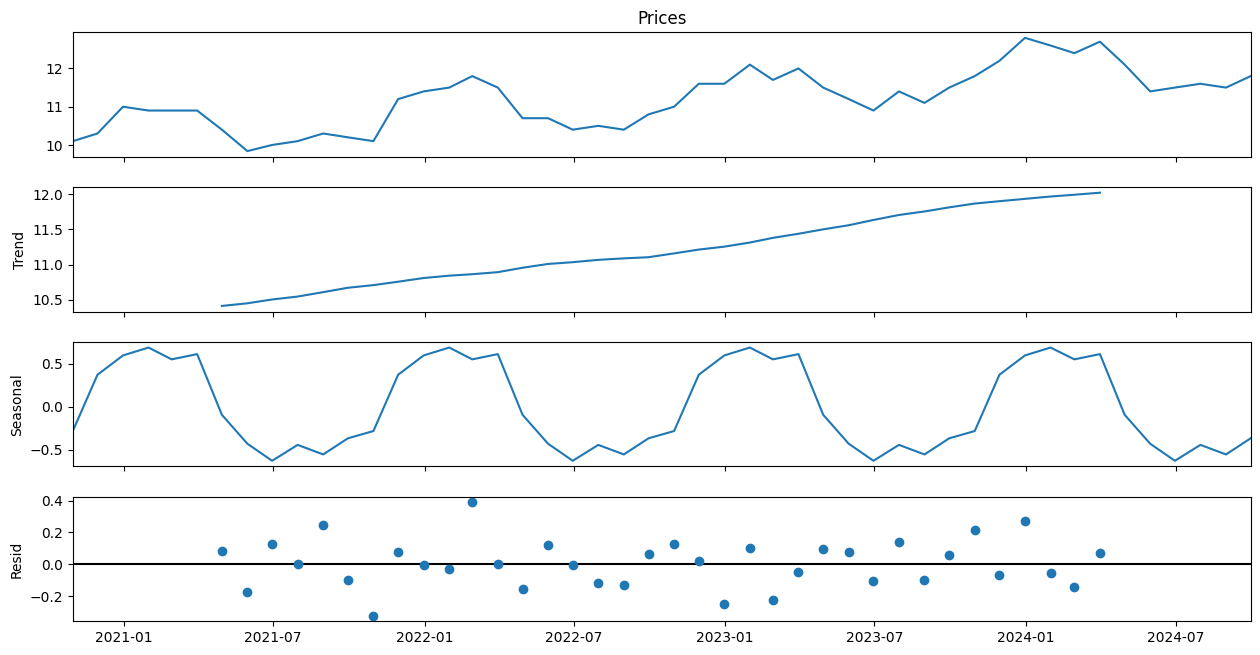

In [70]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(natural_gas['Prices'], model='additive')
trend_comp = decomposition.trend
seasonal_comp = decomposition.seasonal
residual_comp = decomposition.resid

fig = decomposition.plot()
fig.set_size_inches(14, 7)
plt.show()

Notes: 
- clear linear upward trend
- clear seasonal pattern, peaking at the beginning of each year and dipping around the middle of the year (june-july)
- prices increases steadily

## Simple Regression

In [71]:
prices = natural_gas['Prices'].values
dates = natural_gas.index.values

In [72]:
start_date = date(2020,10,31)
end_date = date(2024,9,30)
months = []
year = start_date.year
month = start_date.month + 1
while True:
    current = date(year, month, 1) + timedelta(days=-1)
    months.append(current)
    if current.month == end_date.month and current.year == end_date.year:
        break
    else:
        month = ((month + 1) % 12) or 12
        if month == 1:
            year += 1
        
days_from_start = [(day - start_date ).days for day in months]

Start with simple regression with y = Ax + B to capture the linear trend

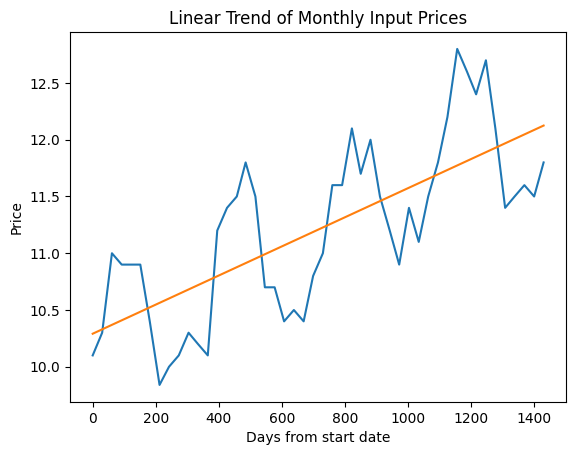

In [73]:
def simple_regression(x,y):
	xbar = np.mean(x)
	ybar = np.mean(y)
	slope = np.sum((x-xbar) * (y-ybar))/np.sum((x-xbar)**2)
	intercept = ybar - slope*xbar
	return slope, intercept

time = np.array(days_from_start)
slope, intercept = simple_regression(time, prices)

# Plot linear trend
plt.plot(time, prices)
plt.plot(time, time * slope + intercept)
plt.xlabel('Days from start date')
plt.ylabel('Price')
plt.title('Linear Trend of Monthly Input Prices')
plt.show()

## Bilinear Regression

Now we want to capture the variation. Given the nature of the plot as well as the fact that natural gas is used more in winter and less in summer, we can assume the frequency of the price movements to be around a year and can use bilinear regression. 

Text(0.5, 1.0, 'Smoothed Estimate of Monthly Input Prices')

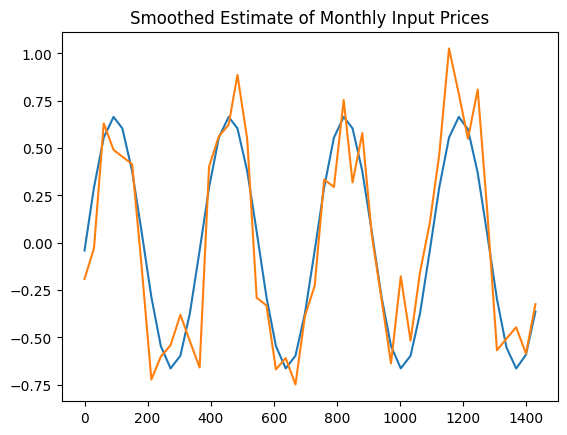

In [74]:
#removes the linear trend of the data
sin_prices = prices - (time * slope + intercept)

#calculate sinusoidal components to the yearly cycle
sin_time = np.sin(time * 2 * np.pi / (365))
cos_time = np.cos(time * 2 * np.pi / (365))

def bilinear_regression(y, x1, x2):
    # Bilinear regression without an intercept amounts to projection onto the x-vectors
    slope1 = np.sum(y * x1) / np.sum(x1 ** 2)
    slope2 = np.sum(y * x2) / np.sum(x2 ** 2)
    return(slope1, slope2)

slope1, slope2 = bilinear_regression(sin_prices, sin_time, cos_time)

# We now recover the original amplitude and phase shift as A = slope1 ** 2 + slope2 ** 2, z = tan^{-1}(slope2/slope1)
amplitude = np.sqrt(slope1 ** 2 + slope2 ** 2)
shift = np.arctan2(slope2, slope1)

# Plot smoothed estimate of full dataset
plt.plot(time, amplitude * np.sin(time * 2 * np.pi / 365 + shift))
plt.plot(time, sin_prices)
plt.title('Smoothed Estimate of Monthly Input Prices')

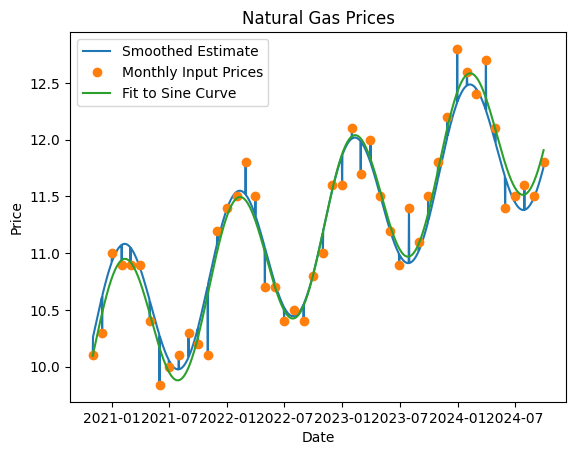

In [75]:
def interpolate(date):
    days = (date - pd.Timestamp(start_date)).days
    if days in days_from_start:
        # Exact match found in the data
        return prices[days_from_start.index(days)]
    else:
        # Interpolate/extrapolate using the sin/cos model
        return amplitude * np.sin(days * 2 * np.pi / 365 + shift) + days * slope + intercept

# Create a range of continuous dates from start date to end date
continuous_dates = pd.date_range(start=pd.Timestamp(start_date), end=pd.Timestamp(end_date), freq='D')

# Plot the smoothed estimate of the full dataset using interpolation
plt.plot(continuous_dates, [interpolate(date) for date in continuous_dates], label='Smoothed Estimate')

# Fit the monthly input prices to the sine curve
x = np.array(days_from_start)
y = np.array(prices)
fit_amplitude = np.sqrt(slope1 ** 2 + slope2 ** 2)
fit_shift = np.arctan2(slope2, slope1)
fit_slope, fit_intercept = simple_regression(x, y - fit_amplitude * np.sin(x * 2 * np.pi / 365 + fit_shift))
plt.plot(dates, y, 'o', label='Monthly Input Prices')
plt.plot(continuous_dates, fit_amplitude * np.sin((continuous_dates - pd.Timestamp(start_date)).days * 2 * np.pi / 365 + fit_shift) + (continuous_dates - pd.Timestamp(start_date)).days * fit_slope + fit_intercept, label='Fit to Sine Curve')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Natural Gas Prices')
plt.legend()
plt.show()


## ARIMA

In [76]:
adf_test = adfuller(natural_gas)
print(f'p-value: {adf_test[1]}')

p-value: 0.9732574388448689


## Make Time Series Stationary

In [77]:
natural_gas_diff = natural_gas.diff().dropna()

In [78]:
adf_test = adfuller(natural_gas_diff)
print(f'p-value: {adf_test[1]}')

p-value: 1.7541696852940142e-09


## ACF/PACF

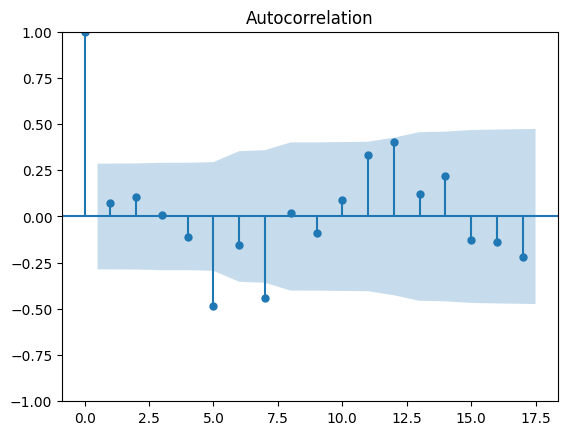

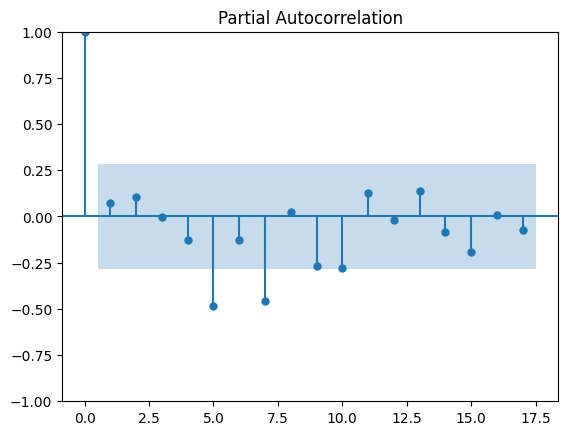

In [79]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(natural_gas_diff)
plt.show()

plot_pacf(natural_gas_diff)
plt.show()

In [80]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(natural_gas_diff, order=(2, 0, 2))
arima_fit = arima_model.fit()

# Forecast the next 10 periods
forecast_steps = 10
forecast = arima_fit.forecast(steps=forecast_steps)

/Users/kevingui/anaconda3/envs/work/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/kevingui/anaconda3/envs/work/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/kevingui/anaconda3/envs/work/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/kevingui/anaconda3/envs/work/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/kevingui/anaconda3/envs/work/lib/pyt

In [81]:
def diff_inv(series_diff, first_value):
    series_inverted = np.r_[first_value, series_diff].cumsum().astype('float64')
    return series_inverted
forecast_values = pd.DataFrame(diff_inv(forecast,natural_gas['Prices'].iloc[0]))
forecast_values

,0
0,10.100000
1,10.461004
2,10.818163
3,11.085876
4,11.202857
5,11.148791
6,10.949855
7,10.671600
8,10.401136
9,10.223451


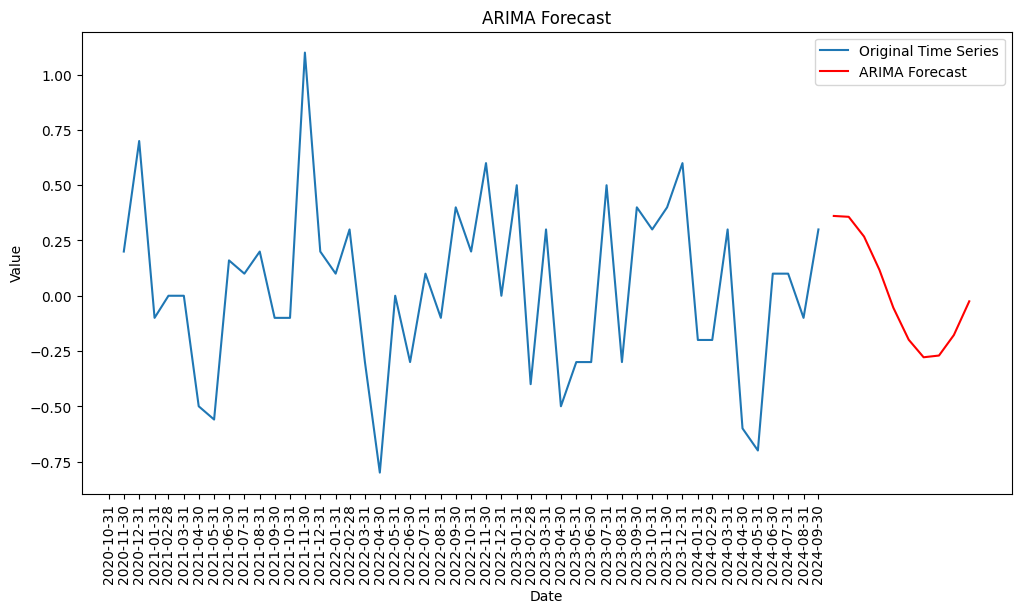

In [82]:
plt.figure(figsize=(12, 6))
plt.plot(natural_gas_diff, label='Original Time Series')
plt.plot(forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(natural_gas.index,rotation=90)
plt.title('ARIMA Forecast')
plt.show()

## Auto-ARIMA

In [83]:
import pmdarima as pm

auto_arima = pm.auto_arima(natural_gas_diff,seasonal=True)
auto_arima

ARIMA(order=(2, 0, 2), scoring_args={}, suppress_warnings=True)

In [84]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   47
Model:               SARIMAX(2, 0, 2)   Log Likelihood                 -12.030
Date:                Fri, 26 Jul 2024   AIC                             36.060
Time:                        15:26:48   BIC                             47.161
Sample:                    11-30-2020   HQIC                            40.238
                         - 09-30-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0098      0.007      1.342      0.180      -0.005       0.024
ar.L1          1.6933      0.048     35.030      0.000       1.599       1.788
ar.L2         -0.9586      0.046    -20.762      0.000      -1.049      -0.868
ma.L1         -1.8178      0.306     -5.941      0.000      -2.418      -1.218
ma.L2          0.9572      0.336      2.852      0.004       0.299       1.615
sigma2         0.0889      0.031      2.892      0.004       0.029       0.149
===================================================================================
Ljung-Box (L1) (Q):                   6.17   Jarque-Bera (JB):                 2.21
Prob(Q):                              0.01   Prob(JB):                         0.33
Heteroskedasticity (H):               0.89   Skew:                             0.48
Prob(H) (two-sided):                  0.82   Kurtosis:                         2.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [85]:
forecast_test_auto = auto_arima.predict(n_periods=12)
auto_forecast_values = diff_inv(forecast_test_auto.values,natural_gas['Prices'].iloc[0])
auto_forecast_values

array([10.1       , 10.49349617, 10.82658674, 11.02323444, 11.04674832,
       10.90788692, 10.66003811, 10.38329001, 10.16207873, 10.06260893,
       10.11604634, 10.3117019 , 10.60160165])

## SARIMAX

In [87]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(natural_gas['Prices'], order=(2, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()
forecast = results.get_forecast(steps=24)


/Users/kevingui/anaconda3/envs/work/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/kevingui/anaconda3/envs/work/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/kevingui/anaconda3/envs/work/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39760D-01    |proj g|=  3.21003D-01


 This problem is unconstrained.



At iterate    5    f=  2.59233D-02    |proj g|=  2.76781D-02

At iterate   10    f=  8.35146D-03    |proj g|=  3.07830D-02

At iterate   15    f=  7.30311D-03    |proj g|=  2.22359D-02

At iterate   20    f=  6.44689D-03    |proj g|=  4.87167D-03

At iterate   25    f=  6.30652D-03    |proj g|=  1.52508D-02

At iterate   30    f=  6.27422D-03    |proj g|=  4.64036D-03

At iterate   35    f=  6.27206D-03    |proj g|=  3.44121D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     58      1     0     0   1.050D-04   6.272D-03
  F =   6.2718497651383098E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

In [88]:
forecast_df = forecast.conf_int()
forecast_df

,lower Prices,upper Prices
2024-10-31,11.548367,12.367185
2024-11-30,12.155605,12.973348
2024-12-31,12.474077,13.309562
2025-01-31,12.584893,13.465795
2025-02-28,12.517349,13.419932
2025-03-31,12.542544,13.468741
2025-04-30,11.925913,12.878344
2025-05-31,11.587101,12.563075
2025-06-30,11.447516,12.446442
2025-07-31,11.661493,12.683823


Objective: given monthly gas price data, be able to predict future ones, looking at patterns in the data and trends and seasonality

Steps to take:

Plot the time series and analyze the seasonality, trend, and residuals through the functions
Fit a simple linear regression line to the graph to capture the linear trend of the time series
Slope is represented as the covariance of x and y to the variance of x and the intercept is calculated by taking the mean of y and subtracting the product of the slope and the mean of x

Then do bilinear regression, calculating the slopes, fitting the detrended data to these sinusoidal components, calculate the amplitude and the phase shift of the sinusoidal component, and plot
Sinusoidal components describe periodic phenomena because they repeat in a regular wave-like pattern and are
Amplitude is the height of the wave and can be calculated as
Phase shift is how much the wave is shifted horizontally from a given reference point and can tell you when a seasonal peak occurs relative to the start of the year
In time series datasets, when there are natural phenomena or economic cycles, there are repeating patterns and sinusoidal components help capture these patterns, the amplitude tells us how much variation occurs, and phase shift helps us understand when certain events or peaks occur in the cycle

Finally, interpolate the price using the sinusoidal model if not given
A is amplitude
